<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-a01685424/blob/main/S8_CD_Notebook_2_K_means_TecMty_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Models

---
# Actividad Semanal -- 7
## Regresiones y K means
### Ejercicio 3

### Materia: Ciencia y analítica de datos
**Profesora: María de la Paz Rico Fdz.

**Alumno: Fernando Alfredo Rojas Estrella**

**Matricula: A01685424**


---



Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [77]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [79]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [80]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [82]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

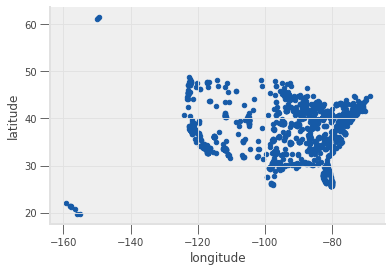

In [83]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [84]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [117]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [86]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [87]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [88]:
#mapa

world= gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world= world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [89]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

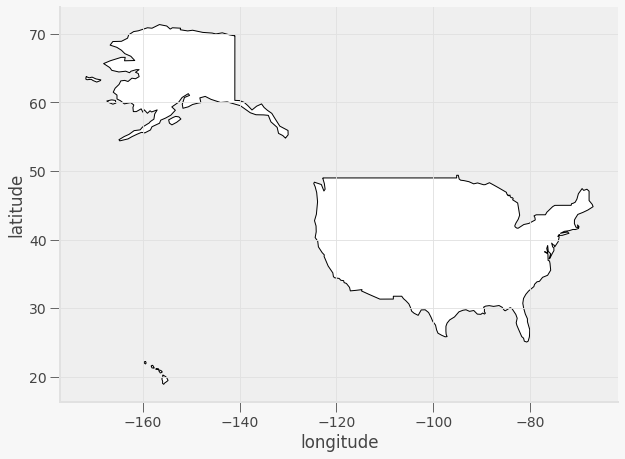

In [90]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

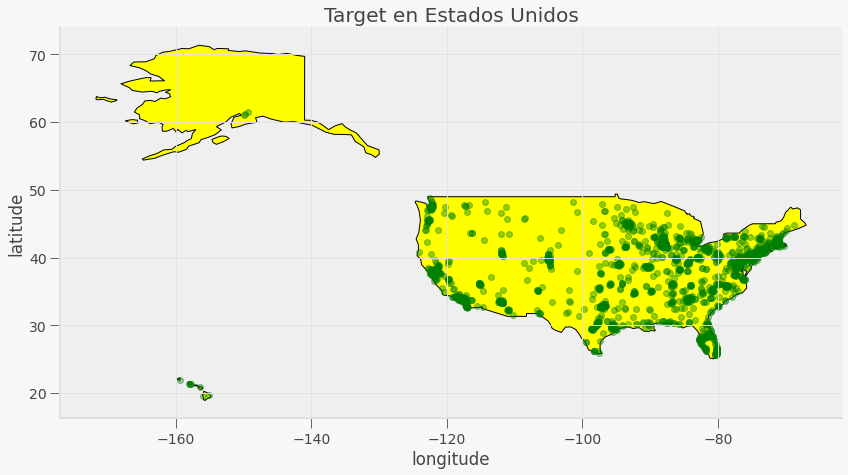

In [91]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before9 --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(14,12))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='yellow')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='green', alpha = 0.4)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [92]:
#tu codigo aquí

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


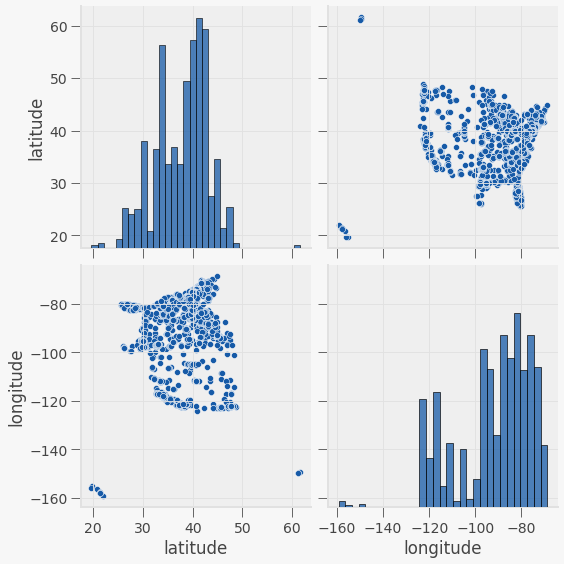

In [93]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Implementar K-means

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


sb.pairplot(df.dropna(),size=4,vars=["latitude","longitude"],kind='scatter')

In [94]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Definición de la entrada

X= np.array(df[["latitude","longitude"]])
#y = np.array(df['categoria'])
X.shape


(1839, 2)

k means: [KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9), KMeans(n_clusters=10), KMeans(n_clusters=11), KMeans(n_clusters=12), KMeans(n_clusters=13), KMeans(n_clusters=14)]
score: [-527995.4430694166, -171146.62599564376, -104757.3749142418, -83653.68049747549, -62083.572192977364, -46975.80748576473, -38599.406038565896, -32109.363178739266, -25442.875091115176, -22321.66258497331, -19648.397709773493, -17179.56691672567, -14498.996582276002, -12608.763022979056]


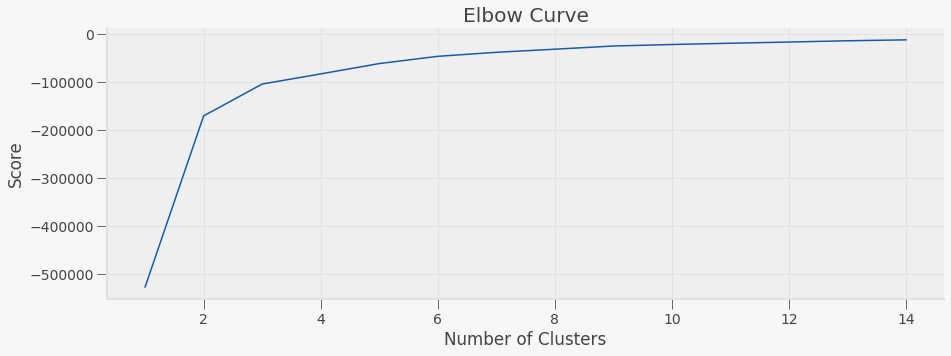

In [95]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Obteniendo el valor de "K"

Nc= range(1, 15)
kmeans= [KMeans(n_clusters=i) for i in Nc]
print('k means:',kmeans)
score= [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
print('score:',score)
plt.figure(figsize= (15,5))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Se considera por la gráfica de codo, a k=3 para entrenar el modelo (3 clusters). De la gráfica se podría también considerar k=2 y k=6, recordemos esto es un valor arbitrarío inicialmente.

In [111]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Implementando k-means con 3 clusters (k=3)

kmeans_c3= KMeans(n_clusters= 3).fit(X)
centroids= kmeans_c3.cluster_centers_
etiquetas= kmeans_c3.predict(X)
C= kmeans_c3.cluster_centers_
df_centroids= pd.DataFrame(centroids)
df_centroids.columns= ['latitude', 'longitude']

df_centroids["Coordinates"]= list(zip(df_centroids.longitude, df_centroids.latitude))
df_centroids["Coordinates"]= df_centroids["Coordinates"].apply(Point)

print('Centroides obtenidos\n')
gdf_centroids= gpd.GeoDataFrame(df_centroids, geometry="Coordinates")
gdf_centroids.head()

Centroides obtenidos



,latitude,longitude,Coordinates
0,37.487342,-118.624473,POINT (-118.62447 37.48734)
1,37.789554,-78.569908,POINT (-78.56991 37.78955)
2,37.980063,-93.327172,POINT (-93.32717 37.98006)


Etiquetas: [2 2 2 ... 0 2 0]
tamaño: (1839,) 

C: [[  37.48734203 -118.62447332]
 [  37.789554    -78.56990807]
 [  37.98006261  -93.3271723 ]] 


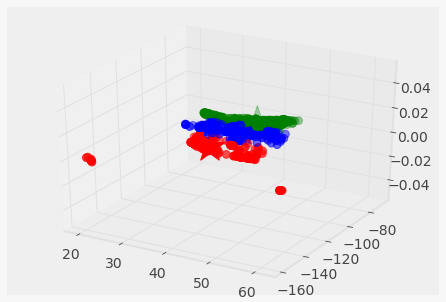

In [128]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Obteniendo etiquetas

print('Etiquetas:',etiquetas)
print('tamaño:',etiquetas.shape,'\n')
print('C:',C,'')

colores=['red','green','blue']
asignar=[]
for row in etiquetas:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)

In [138]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Asignando etiquetas

df_asignar= pd.DataFrame(asignar)
df_etiquetas= pd.DataFrame(etiquetas)
df_etiquetas
df_clasificado= df
df['etiqueta']= df_etiquetas
df['color']= df_asignar
df_clasificado.head(1250)

,name,latitude,longitude,address,phone,website,Coordinates,etiqueta,color
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423),2,blue
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455),2,blue
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287),2,blue
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015),2,blue
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606),1,green
...,...,...,...,...,...,...,...,...,...
1245,Rocky Mount,35.972092,-77.813319,"731 Sutters Creek Blvd, Rocky Mount, NC 27804-...",252-443-1195,https://www.target.com/sl/rocky-mount/962,POINT (-77.81332 35.97209),1,green
1246,Wake Forest,35.974801,-78.541773,"12000 Retail Dr, Wake Forest, NC 27587-7353",919-761-1001,https://www.target.com/sl/wake-forest/1504,POINT (-78.54177 35.97480),1,green
1247,Wesley Chapel,34.999494,-80.696664,"6350 Weddington Rd, Wesley Chapel, NC 28104-7925",704-234-5271,https://www.target.com/sl/wesley-chapel/2395,POINT (-80.69666 34.99949),1,green
1248,Wilmington,34.249041,-77.880852,"4711 New Centre Dr, Wilmington, NC 28405-3442",910-395-5057,https://www.target.com/sl/wilmington/1107,POINT (-77.88085 34.24904),1,green


In [132]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Contando clusters

cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=df_clasificado.groupby('etiqueta').size()
cantidadGrupo

,color,cantidad
0,red,385
1,green,826
2,blue,628


In [133]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Buscando las tiendas más cercanass a cada centroide

closest, _= pairwise_distances_argmin_min(kmeans_c3.cluster_centers_, X)
closest

array([ 212, 1689,  998])

In [139]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# Encontrando los nombres de tiendas más cercanas a los centroides encontrados de cada cluster

name= df_clasificado['name'].values
address= df_clasificado['address'].values
etiqueta= df_clasificado['etiqueta'].values
for row in closest:
    print('Nombre de la tienda de Targuet:',name[row],'\n\t\t     dirección:',address[row],'\n\t\t     cluster:',etiqueta[row])

Nombre de la tienda de Targuet: Clovis 
		     dirección: 900 Shaw Ave, Clovis, CA 93612-3900 
		     cluster: 0
Nombre de la tienda de Targuet: Charlottesville 
		     dirección: 312 Connor Dr, Charlottesville, VA 22911-5605 
		     cluster: 1
Nombre de la tienda de Targuet: Osage Beach 
		     dirección: 919 Highway D, Osage Beach, MO 65065-3169 
		     cluster: 2


Las 3 tiendas encontradas (Osage Beach, Charlottesville y Clovis) son las que se encuentran mejor ubicadas para ser los centros de distribución y almacenaje de las tiendas Target. Justo las 3 tiendas se encuentran en California que puede atender a eso datos que inicialmente parecerían atipicos, y por parte de Misuri y Virginia apoyarían en la distribución en la zona norte y sur de USA.

### Encuentra el numero ideal de almacenes, justifica tu respuesta:

- Encuentra las latitudes y longitudes de los almacenes
  R. Cómo se explico más arriba, justo el valor en donde la cruva de codo dobla es un buen indicador para tomar en consideración esa cantidad de clusters. En esté caso fueron 3.

- ¿Qué ciudad es?
  R. Las ciudades son California, Misuri y Virginia.

- ¿A cuantas tiendas va surtir?
  R. En la siguiente tabla se puede observar la distribución:
  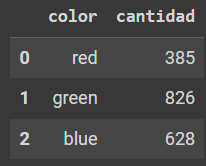 

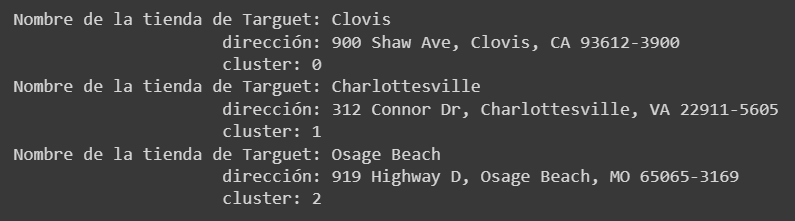


- ¿Sabes a que distancia estará?
  R. Es posible saberlo a partir de las longitudes y latitudes de cada tienda, sin embargo no sería un dato real pensando en que se debe tomar en consideración los canales de comunicación existentes entre cada tienda y los posibles almacenenes.

- ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.
  R. A partir de la gráfica de codo en la que se utiliza el valor de cluster que coincida con el punto en el que la curva dobla.


### Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.

- ¿Qué librerías nos pueden ayudar a graficar este tipo de datos?
  R. Algunas de la librerías para python que se pueden ocupar para gráficar datos geospaciles (GIS) son: Arcpy, Geopandas, PyProj, PySAL, entre otros.

- ¿Consideras importante que se grafique en un mapa?
  R. Definitivamente sí, inclusive hice un ejercicio en el que gráfique la misma información y se alcanzaba a entender que se estaba viendo un mapa pero no era contundente. 

- ¿Por qué?
  R.  Solamente ver puntos sin un contexto geográfico no nos ayuda a entender a completitud de la distribución de los clusters encontrados para este caso. En mi caso utilizo mucho gráficos de nuestro país para poder representar la distribución de enfermedades, de la operación de sistemas, de riesgos, entre otras casos.

###Conclusiones:

- Finalmente concluyo de está actividad la importancia de poder ir viendo con forme se va avanzando en el modelado qué es lo que se está encontrando, más en el caso de modelos de machine learning no supervisado en dónde a priori no sabemos qué vamos a encontrar y por tal razón las visualizaciones de la información son muy útiles para ir tomando decisiones en el camino.

In [ ]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# 

In [ ]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# 

In [ ]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# 